In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
!uv pip install --upgrade -q yfinance

In [3]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [4]:
from typing import Literal
from langchain_community.tools.yahoo_finance_news import YahooFinanceNewsTool
from langchain_core.messages import HumanMessage
from langgraph.graph import MessagesState
from langchain.agents import create_agent
from langgraph.types import Command

market_research_agent = create_agent(
    model=llm,
    tools=[YahooFinanceNewsTool()],
    system_prompt= "You are a market researcher. provide fact only not opinions"
)

def market_research(state: MessagesState) -> Command[Literal['supervisor']]:
    result = market_research_agent.invoke(state)
    print(result)
    last_message = result['messages'][-1].content
    return Command(
        goto='supervisor', 
        update={'messages': [HumanMessage(last_message, name='market_research')]}
    )
    
        


USER_AGENT environment variable not set, consider setting it to identify your requests.


In [5]:
import yfinance as yf
from langchain.tools import tool

@tool
def get_stock_price(ticker: str) -> dict:
    """Given a stock ticker, return the price data for the past 10 days"""
    stock_info = yf.download(ticker, period='1mo').to_dict()
    return stock_info

stock_research_tools = [get_stock_price]

stock_research_agent = create_agent(
    model=llm,
    tools=stock_research_tools,
    system_prompt="You are a stock researcher. provide fact only not opinions"
)

def stock_research(state: MessagesState) -> Command[Literal['supervisor']]:
    result = stock_research_agent.invoke(state)
    last_message = result['messages'][-1].content
    return Command(
        goto='supervisor', 
        update={'messages': [HumanMessage(last_message, name='stock_research')]}
    )

In [6]:
@tool
def company_research(ticker: str) -> dict:
    """Given a ticker, return the financial and sec filings information"""
    company_info = yf.Ticker(ticker)
    financial_info = company_info.get_financials()
    sec_fillings = company_info.get_sec_filings()
    return {
        'financial_info': financial_info,
        'sec_fillings': sec_fillings
    }

company_research_tools = [company_research]

company_research_agent = create_agent(
    model=llm,
    tools=company_research_tools,
    system_prompt="You are a company researcher. provide fact only not opinions"
)

def company_research(state: MessagesState) -> Command[Literal['supervisor']]:
    result = company_research_agent.invoke(state)
    last_message = result['messages'][-1].content
    return Command(
        goto='supervisor', 
        update={'messages': [HumanMessage(last_message, name='company_research')]}
    )

In [21]:
from langchain_core.prompts import PromptTemplate

analyst_prompt = PromptTemplate.from_template(
    """You are a stock market analyst. Given the following information, 
Please decide wheter to buy, sell, or hold the stock.

Information:
{messages}"""
)

analyst_chain = analyst_prompt | llm

def analyst(state: MessagesState):
    result = analyst_chain.invoke({'messages': state['messages'][1:]})

    return {'messages': [result]}

In [23]:
from typing import Literal
from typing_extensions import TypedDict

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["market_research", "stock_research", "company_research"]
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    f" following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)


class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""
    next: Literal[*options]



def supervisor(state: MessagesState) -> Command[Literal[*members, "analyst"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)
    goto = response["next"]
    if goto == "FINISH":
        goto = "analyst"

    return Command(goto=goto)

In [28]:
from langgraph.graph import StateGraph, START

graph_builder = StateGraph(MessagesState)

graph_builder.add_node(supervisor)
graph_builder.add_node(market_research)
graph_builder.add_node(stock_research)
graph_builder.add_node(company_research)
graph_builder.add_node(analyst)

In [29]:
graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("analyst", END)

In [30]:
graph = graph_builder.compile()

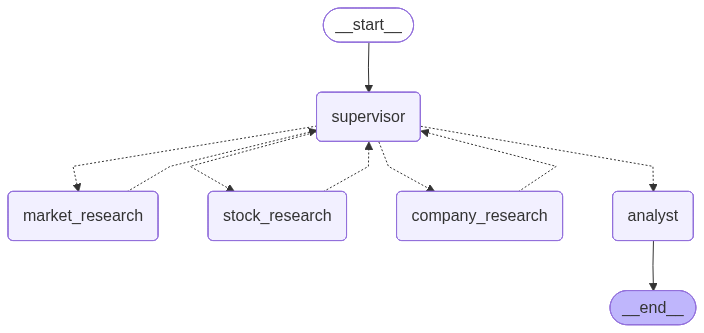

In [31]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [32]:
for chunk in graph.stream(
    {"messages": [("user", "Would you invest in Snowflake?")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

Would you invest in Snowflake?
================================ Human Message =================================
Name: stock_research

I can provide factual information related to Snowflake's stock, including its price history and market data, but I cannot provide investment advice or personal opinions. Would you like to see the latest stock price data for Snowflake?


/var/folders/z1/kkrl3fn92r95z4l05sfrl4x40000gn/T/ipykernel_59473/498161808.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_info = yf.download(ticker, period='1mo').to_dict()
[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: stock_research

Here is the recent stock price data for Snowflake (Ticker: SNOW) over the past 10 trading days:

- **October 10, 2025**
  - Close: $242.17
  - High: $255.39
  - Low: $241.12
  - Open: $253.00
  - Volume: 5,062,700
  
- **October 09, 2025**
  - Close: $250.67
  - High: $253.60
  - Low: $245.27
  - Open: $249.96
  - Volume: 6,562,600

- **October 08, 2025**
  - Close: $250.21
  - High: $251.81
  - Low: $237.05
  - Open: $239.04
  - Volume: 7,518,200

- **October 07, 2025**
  - Close: $234.81
  - High: $244.15
  - Low: $231.07
  - Open: $243.28
  - Volume: 4,898,700

- **October 06, 2025**
  - Close: $242.52
  - High: $245.76
  - Low: $239.50
  - Open: $240.36
  - Volume: 5,131,200

- **October 03, 2025**
  - Close: $235.09
  - High: $242.50
  - Low: $233.24
  - Open: $242.50
  - Volume: 4,073,700

- **October 02, 2025**
  - Close: $240.54
  - High: $241.12
  - Low: $234.01
  - Open: $23